# Import

In [19]:
import copy
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets
from torchvision.transforms.v2 import (
    ToTensor,
    RandomHorizontalFlip,
    Compose,
    RandomResizedCrop,
    RandomShortestSize,
    AutoAugment,
)

from torchvision.transforms.autoaugment import AutoAugmentPolicy
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Setup

In [20]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True

"""training parameters"""
# ImageNet정도 대규모 일 때에 조금 효과있는 것 같아서, CIFAF에서는 제외.
if DATASET == "ImageNet2012":
    USE_AMP = True
else:
    USE_AMP = False

# USE_AMP = False

LOAD_BEFORE_WEIGHTS = False

NUM_EPOCHS = 5000

# Loading the dataset

## Define Dateloader

In [21]:
class Submean(torch.nn.Module):
    # Subtract the mean from each pixel along each channel
    def __init__(self):
        super().__init__()
        return None

    def __call__(self, tensor):
        _mean = tensor.mean(axis=(1, 2))
        tensor = tensor - _mean[:, None, None]

        return tensor


class PaddingWithRandomResizedCrop(RandomResizedCrop):
    # Add padding to the image
    def __call__(self, img):
        img = F.pad(img, (4, 4, 4, 4), mode="constant", value=0)
        return super().__call__(img)


class LoadDataset(Dataset):
    """
    input :
        - root : "data"
        - seceted_data :
            - "CIFAR10" or "CIFAR100" : Load ~ from torchvision.datasets
            - "ImageNet2012" : Load ~ from Local
    pre-processing:
        - CIFAR10, CIFAR100 :
            - split train/valid with 9:1 ratio
            - train :
                ToTensor(),
                Random Horizontal Flip (p = 0.5),
                4 pixel zero padding and crop to (32,32,3),
                Submean(),
            - valid, test :
                ToTensor(),
                Submean(),
        - ImageNet2012 :
            - train :
                ToTensor(),
                RandomShortestSize(min_size=256, max_size=480, antialias=True),
                RandomResizedCrop([224, 224], antialias=True),
                RandomHorizontalFlip(self.Randp),
                Submean(),
            - valid :
                ToTensor(),
                RandomShortestSize(min_size=[224, 256, 384, 480, 640], antialias=True),
                RandomResizedCrop([224, 224], antialias=True),
                Submean(),
    output :
        - self.train_data
        - self.valid_data
        - self.test_data
        - num of classes
    """

    def __init__(self, root, seceted_dataset="CIFAR100"):
        super().__init__()
        self.Randp = 0.5
        self.dataset_name = seceted_dataset

        if self.dataset_name[:5] == "CIFAR":
            self.split_ratio = 0.9
            dataset_mapping = {
                "CIFAR100": datasets.CIFAR100,
                "CIFAR10": datasets.CIFAR10,
                # Add more datasets if needed
            }
            cifar_default_transforms = Compose(
                [
                    ToTensor(),
                    Submean(),
                ],
            )
            """CIFAR10, CIFAR100에서는 ref_train에 split ratio대로 적용해서 잘라냄."""
            ref_train = dataset_mapping[self.dataset_name](
                root=root,
                train=True,
                download=False,
                transform=cifar_default_transforms,
            )
            self.test_data = dataset_mapping[self.dataset_name](
                root=root,
                train=False,
                download=False,
                transform=cifar_default_transforms,
            )
            # Split to train and valid set
            total_length = len(ref_train)
            train_length = int(total_length * self.split_ratio)
            valid_length = total_length - train_length
            self.train_data, self.valid_data = random_split(
                ref_train, [train_length, valid_length]
            )
            # Apply transform at each dataset
            self.train_data.transform = copy.deepcopy(cifar_default_transforms)
            self.valid_data.transform = copy.deepcopy(cifar_default_transforms)

            ####### 둘 중 하나 골라서 #################################
            # self.train_data.transform.transforms.append(PaddingWithRandomResizedCrop([32, 32]))
            self.train_data.transform.transforms.append(
                AutoAugment(policy=AutoAugmentPolicy.CIFAR10)
            )
            #######################################################
            
            self.train_data.transform.transforms.append(
                RandomHorizontalFlip(self.Randp),
            )
            # Copy classes data
            self.train_data.classes = ref_train.classes
            self.valid_data.classes = ref_train.classes

            self.train_data.class_to_idx = ref_train.class_to_idx
            self.valid_data.class_to_idx = ref_train.class_to_idx

        elif self.dataset_name == "ImageNet2012":
            self.ImageNetRoot = "data/" + self.dataset_name + "/"

            self.train_data = datasets.ImageFolder(
                root=self.ImageNetRoot + "train",
                transform=Compose(
                    [
                        ToTensor(),
                        Submean(),
                        # with AutoAugment
                        AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
                        RandomShortestSize(min_size=256, max_size=480, antialias=True),
                        RandomResizedCrop([224, 224], antialias=True),
                    ]
                ),
            )
            self.valid_data = datasets.ImageFolder(
                root=self.ImageNetRoot + "val",
                transform=Compose(
                    [
                        ToTensor(),
                        Submean(),
                        # RandomShortestSize(
                        #     min_size=[224, 256, 384, 480, 640], antialias=True
                        # ),
                        # RandomResizedCrop([224, 224], antialias=True),
                    ]
                ),
            )
            self.test_data = self.valid_data

        else:
            raise ValueError(f"Unsupported dataset: {self.dataset_name}")

        return

    def unpack(self):
        print("-----------------------------------------------------------------------")
        print("Dataset : ", self.dataset_name)
        print("- Length of Train Set : ", len(self.train_data))
        print("- Length of Valid Set : ", len(self.valid_data))
        if self.dataset_name == "ImageNet":
            pass
        else:
            print("- Length of Test Set : ", len(self.test_data))
        print("- Count of Classes : ", len(self.train_data.classes))
        print("-----------------------------------------------------------------------")
        return (
            self.train_data,
            self.valid_data,
            self.test_data,
            len(self.train_data.classes),
        )

## Confirm that the dataset is loaded properly

In [22]:
_dataset = LoadDataset(root="data", seceted_dataset=DATASET)
train_data, valid_data, test_data, COUNT_OF_CLASSES = _dataset.unpack()

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)

print("train.transforms =", train_data.transform)
print("valid.transforms =", valid_data.transform)
print("test.transforms =", test_data.transform)

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------
train.transforms = Compose(
      ToTensor()
      Submean()
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomHorizontalFlip(p=0.5)
)
valid.transforms = Compose(
      ToTensor()
      Submean()
)
test.transforms = Compose(
      ToTensor()
      Submean()
)


In [23]:
print(train_dataloader.batch_size)
print(valid_dataloader.batch_size)
print(test_dataloader.batch_size)

256
256
256


In [24]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-1.9378e-09, -8.7766e-11, -3.5475e-09])
Shape of y: torch.Size([256]) torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

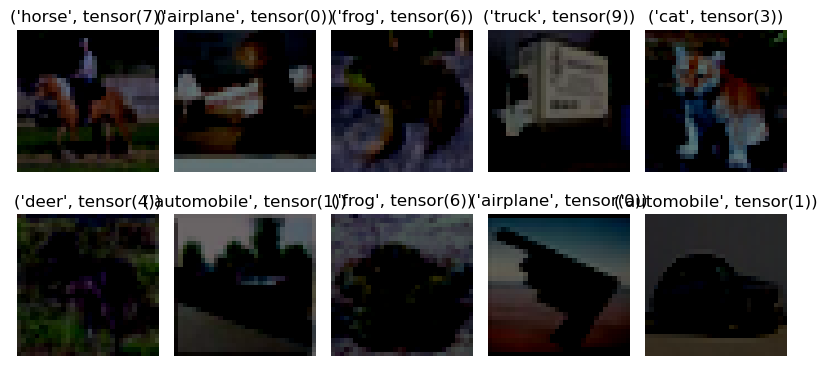

In [25]:
if DATASET != "ImageNet2012":
    # Get the class names
    class_names = test_dataloader.dataset.classes
    count = 0

    # Create a subplot with 2 rows and 5 columns
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    # Iterate over the first batch of images and labels
    for images, labels in test_dataloader:
        # Convert the images to numpy arrays
        images = images.numpy()
        
        # Iterate over the images and labels
        for i in range(len(images)):
            # Get the image and label
            image = images[i]
            label = labels[i]
            
            # Convert the image from tensor to numpy array
            image = np.transpose(image, (1, 2, 0))
            
            # Plot the image in the appropriate subplot
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            
            # Increment the count
            count += 1
            
            # Break the loop if we have displayed 10 images
            if count == 10:
                break
                
        # Break the loop if we have displayed 10 images
        if count == 10:
            break

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


# Define ResNet

In [26]:
class Block(nn.Module):
    """
    - Downsample_option :
        (A) zero-padding shortcuts are used for increasing dimensions, 
            and all shortcuts are parameter- free (the same as Table 2 and Fig. 4 right); 
        (B) projection shortcuts are used for increasing dimensions, and other shortcuts are identity;
        (C) all shortcuts are projections.
    """
    def __init__(self, inputs, outputs, Downsample_option=None, device="cuda"):
        super().__init__()
        self.device = device
        self.Downsample_option = Downsample_option
        self.relu = nn.ReLU(inplace=False)

        self.conv1 = nn.Conv2d(inputs, outputs, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1)
        nn.init.kaiming_normal_(self.conv1.weight, mode="fan_out", nonlinearity="relu")

        self.conv2 = nn.Conv2d(outputs, outputs, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1)
        nn.init.kaiming_normal_(self.conv2.weight, mode="fan_out", nonlinearity="relu")


        if self.Downsample_option == "A":
            self.conv1.stride = 2

        if self.Downsample_option == "C":
            self.conv1.stride = 2
            self.conv_down = nn.Conv2d(
                inputs, outputs, kernel_size=1, stride=2, bias=False
            )
            # 여기 BN빼니까 완전히 망가져버림. acc 10% 찍힘.
            nn.init.kaiming_normal_(
                self.conv_down.weight, mode="fan_out", nonlinearity="relu"
            )
            self.bn_down = nn.BatchNorm2d(
                outputs,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True,
            )

    def forward(self, x):
        # print("x1(identity) :", x.shape)
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # print("x2 :", x.shape)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.Downsample_option == "A":
            identity = F.max_pool2d(identity, kernel_size=2, stride=2)
            identity = torch.cat(
                [identity, torch.zeros(identity.shape).to(self.device)], dim=1
            )
        elif self.Downsample_option == "C":
            identity = self.conv_down(identity)
            identity = self.bn_down(identity)

        # print("x3(downsampled) :", identity.shape)
        # print("x4 :", identity.shape)
        x = x + identity  # 여기 x+=identity로 하면 안 됨. inplace operation이라서.
        x = self.relu(x)
        return x

In [27]:
class MyResNet34(nn.Module):
    def __init__(self, num_classes, BlockClass=Block):
        super().__init__()
        self.num_classes = num_classes
        self.BlockClass = BlockClass
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv64blocks = nn.Sequential(
            self.BlockClass(64, 64), self.BlockClass(64, 64), self.BlockClass(64, 64)
        )
        self.conv128blocks = nn.Sequential(
            self.BlockClass(64, 128, Downsample_option="C"),
            self.BlockClass(128, 128),
            self.BlockClass(128, 128),
            self.BlockClass(128, 128),
        )
        self.conv256blocks = nn.Sequential(
            self.BlockClass(128, 256, Downsample_option="C"),
            self.BlockClass(256, 256),
            self.BlockClass(256, 256),
            self.BlockClass(256, 256),
            self.BlockClass(256, 256),
            self.BlockClass(256, 256),
        )
        self.conv512blocks = nn.Sequential(
            self.BlockClass(256, 512, Downsample_option="C"),
            self.BlockClass(512, 512),
            self.BlockClass(512, 512),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features=512, out_features=self.num_classes, bias=True)

        nn.init.kaiming_normal_(self.conv1.weight, mode="fan_out", nonlinearity="relu")
        nn.init.kaiming_normal_(self.fc1.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv64blocks(x)
        x = self.conv128blocks(x)
        x = self.conv256blocks(x)
        x = self.conv512blocks(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)  

        return x

In [28]:
class MyResNet_CIFAR(nn.Module):
    def __init__(self, num_classes, num_layer_factor, BlockClass=Block):
        super().__init__()
        self.num_layer_factor = num_layer_factor
        self.num_classes = num_classes
        self.BlockClass = BlockClass

        """
        - The subsampling is preformed by convolutions with a stride 2.
        - The network ands with a global average pooling, a 10-way fully-connected layer, and softmax.
        - There are totally 6n+2 stacked weighted layers.
        - When shortcut connections are used, they are connected to the pair of 3x3 layers (totally 3n shortcuts).
        - On this dataset we use ientity shortcuts in all cases (i.e., option A), 
            so out residual models habe exactly the same depth, width, and number of parameters as the plain counterparts.
        
        -------------------------------------
        input = (32x32x3)
        -------------------------------------
        output map size | 32x32 | 16x16 | 8x8
        -------------------------------------
        #layers         |  1+2n |  2n   | 2n
        #filters        |   16  |  32   | 64
        -------------------------------------
        """

        self.conv32blocks = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False
            ),
            self.BlockClass(16, 16),
        )
        self.conv16blocks = nn.Sequential(
            self.BlockClass(16, 32, Downsample_option="A"),
        )
        self.conv8blocks = nn.Sequential(
            self.BlockClass(32, 64, Downsample_option="A"),
        )

        for i in range(1, self.num_layer_factor):
            self.conv32blocks.append(self.BlockClass(16, 16))
            self.conv16blocks.append(self.BlockClass(32, 32))
            self.conv8blocks.append(self.BlockClass(64, 64))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(
            in_features=(64), out_features=self.num_classes, bias=True
        )
        nn.init.kaiming_normal_(self.fc1.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        x = self.conv32blocks(x)
        x = self.conv16blocks(x)
        x = self.conv8blocks(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

## Model Confirm

In [29]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [30]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")
    
elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")
    
# model.named_modules

ResNet-32 for CIFAR10 is loaded.


In [31]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                   | #parameters or shape   | #flops     |
|:-------------------------|:-----------------------|:-----------|
| model                    | 0.464M                 | 17.997G    |
|  conv32blocks            |  23.792K               |  6.363G    |
|   conv32blocks.0         |   0.432K               |   0.113G   |
|    conv32blocks.0.weight |    (16, 3, 3, 3)       |            |
|   conv32blocks.1         |   4.672K               |   1.25G    |
|    conv32blocks.1.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn1    |    32                  |    20.972M |
|    conv32blocks.1.conv2  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn2    |    32                  |    20.972M |
|   conv32blocks.2         |   4.672K               |   1.25G    |
|    conv32blocks.2.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.2.bn1    |    32                  |    20.972M |
|    conv32blocks.2.conv2  |    2.304K              |    0.604

# Define Training

## Define Optimazer
#### ResNet32 for CIFAR10
- SGD
- Batch size = 128 * 2 GPU
- lr : 0.1 -> 0.01 -> 0.001 (at 32k, 48k and terminate on 64k iter)
  - divided by 10 when the error plateaus
- Weight Decay = 0.0001
- Momentum = 0.9
#### ResNet34 for ImageNet2012
- SGD
- Batch size = 256
- lr = 0.1
  - divided by 10 when the error plateaus
  - amount 60k iter
- Weight Decay = 0.0001
- Momentum = 0.9

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters())

## Define Early Stopping

In [33]:
# Early stopping 관련 변수 초기화
best_val_loss = float("inf")
patience = 100  # 몇 번까지 기다릴 것인지
early_stop_counter = 0

## Define Learning Rate schedualer

In [34]:
scheduler_mapping = {"CIFAR100": 300, "CIFAR10": 300, "ImageNet2012": 30}
MIN_LR = 0.0001
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    min_lr=MIN_LR,
)

## Define Auto Mixed Pricision

In [35]:
if USE_AMP == True:
    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

    if LOAD_BEFORE_WEIGHTS == True:
        # Read checkpoint as desired, e.g.,
        checkpoint = torch.load(
            "models/amp/" + DATASET, map_location=lambda storage, loc: storage.cuda(device)
        )
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scaler.load_state_dict(checkpoint["scaler"])

# [Training Loop]

In [36]:
_log_train_loss = []
_log_train_acc = []
_log_valid_loss = []
_log_valid_acc = []
_log_test_loss = []
_log_test_acc = []

for epoch in range(NUM_EPOCHS):
    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] :")

    # Training loop @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm.tqdm(train_dataloader):
        if USE_AMP == True:
            """with auto mixed precision"""
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=USE_AMP
            ):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        else:
            """without auto mixed precision"""
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total

    # Evaluation loop @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    valid_loss /= len(valid_dataloader)
    valid_acc = correct / total

    if DATASET == "ImageNet2012":
        pass
    else:
        # Testing loop @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss /= len(test_dataloader)
        test_acc = correct / total

    # Print epoch statistics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    _log_train_loss.append(train_loss)
    _log_train_acc.append(train_acc)

    print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc*100:.2f}%")
    _log_valid_loss.append(valid_loss)
    _log_valid_acc.append(valid_acc)

    if DATASET == "ImageNet2012":
        pass
    else:
        print(f"Test  Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
        _log_test_loss.append(test_loss)
        _log_test_acc.append(test_acc)

    # Early stopping check
    scheduler.step(valid_loss)
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        early_stop_counter = 0
        # 모델 저장
        torch.save(model.state_dict(), f"models/Myresnet34{DATASET}.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

    print("-" * 50)

[Epoch 1/5000] :


100%|██████████| 176/176 [00:07<00:00, 24.33it/s]


Train Loss: 0.0121 | Train Acc: 22.00%
Valid Loss: 2.4866 | Valid Acc: 18.72%
Test  Loss: 2.4801 | Test Acc: 18.00%
--------------------------------------------------
[Epoch 2/5000] :


100%|██████████| 176/176 [00:06<00:00, 25.72it/s]


Train Loss: 0.0109 | Train Acc: 26.50%
Valid Loss: 2.0485 | Valid Acc: 22.06%
Test  Loss: 2.0566 | Test Acc: 21.85%
--------------------------------------------------
[Epoch 3/5000] :


 18%|█▊        | 31/176 [00:01<00:06, 22.32it/s]


KeyboardInterrupt: 

## Save Info

In [ ]:
if USE_AMP == True:
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict(),
    }
    # Write checkpoint as desired, e.g.,
    torch.save(checkpoint, "models/amp/" + DATASET)

torch.save(model.state_dict(), f"models/Myresnet34{DATASET}.pth")
print("Saved PyTorch Model State to model.pth")

## Training Results

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(_log_train_loss, label="Training Loss")
axs[0].plot(_log_valid_loss, label="Validation Loss")
axs[0].plot(_log_test_loss, label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(_log_train_acc , label="Training Accuracy")
axs[1].plot(_log_valid_acc , label="Validation Accuracy")
axs[1].plot(_log_test_acc, label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()
_log_test_acc[-1] * 100

NameError: name 'plt' is not defined

# Loading Trained Model

In [ ]:
if DATASET == "ImageNet2012":
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
else:
    model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)
model.load_state_dict(torch.load(f"models/Myresnet34{DATASET}.pth"))

In [ ]:
model.named_modules